In [96]:
import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np

import matplotlib.pyplot as plt

import re
from collections import defaultdict
import glob

plt.rcParams['figure.figsize'] = [10, 5]
_EPOCH = 250

In [127]:
def get_results(d='cifar10'):

    expdir = '/tmp/deepncm/%s_resnet/' %(d)            
    explist = glob.glob('%s/*/eval/events.out.tfevents.*.bike' %(expdir))
    explist.sort()
    
    rdict = dict()

    for expfile in explist:
        name = expfile.split('/')[4]
        fname = expfile.split('/')[6]
        n = name.split('_')[0]
        if n == 'softmax' or n == 'onlinemean':
            lr = name.split('_')[1]
            p  = "%s0" %(n[0])
        else:
            p  = name.split('_')[1]
            lr = name.split('_')[2]

        x = EventAccumulator(path=expfile)
        x.Reload()
        acc = np.asarray([(s.step, s.value) for s in x.Scalars('accuracy')])
        A   = np.zeros((_EPOCH,2))
        A[0:acc.shape[0],:] = acc
        print ("%8s | %10s | %5s | %7s | (%3d %1d) | %s" %(d,n,p,lr,acc.shape[0],acc.shape[1],name))
        rdict[name] = {'name':n,'par':p,'lr':float(lr[2:]),'acc':A}
    
    return rdict

In [128]:
def plot_results_acc(rdict=None,m=["onlinemean"],opp="|",tStr=""):
    if isinstance(m, str):
        s = [k for k in rdict.keys() if (m in k)]
        t = m
    elif len(m) == 1:
        s = [k for k in rdict.keys() if (m[0] in k)]
        t = m[0]
    else:
        assert len(m) == 2,"plot results works with 1 or 2 constraints"
        t = "%s %s %s" %(m[0],opp,m[1])
        if opp == "&":
            s = [k for k in rdict.keys() if (m[0] in k and m[1] in k)]
        else:
            s = [k for k in rdict.keys() if (m[0] in k or m[1] in k)]
            

    Y = np.concatenate([rdict[i]['acc'][:,1] for i in s]).reshape([-1,250]).transpose()
    X = np.arange(0,_EPOCH)
    #X = rdict[s[0]]['acc'][:,0]
    
    L = ["%3s-%s-%5.2e (%5.2f)" %(rdict[i]['name'][0:3],rdict[i]['par'][1:],rdict[i]['lr'], 100*rdict[i]['acc'][:,1].max()) for i in s]
    plt.plot(X,Y,linewidth=2.0)
    plt.legend(L)
    plt.title(tStr+t)

In [129]:
c10dict = get_results(d='cifar10')
c100dict = get_results(d='cifar100')

 cifar10 |  decaymean |   d50 | lr1e-01 | (250 2) | decaymean_d50_lr1e-01
 cifar10 |  decaymean |   d50 | lr1e-02 | ( 52 2) | decaymean_d50_lr1e-02
 cifar10 |  decaymean |   d75 | lr1e-01 | (250 2) | decaymean_d75_lr1e-01
 cifar10 |  decaymean |   d75 | lr1e-02 | ( 50 2) | decaymean_d75_lr1e-02
 cifar10 |  decaymean |   d90 | lr1e-01 | (250 2) | decaymean_d90_lr1e-01
 cifar10 |  decaymean |   d90 | lr1e-02 | (250 2) | decaymean_d90_lr1e-02
 cifar10 |  decaymean |   d95 | lr1e-01 | (250 2) | decaymean_d95_lr1e-01
 cifar10 |  decaymean |   d95 | lr1e-02 | (250 2) | decaymean_d95_lr1e-02
 cifar10 |    omreset | r0100 | lr1e-01 | (250 2) | omreset_r0100_lr1e-01
 cifar10 |    omreset | r0100 | lr1e-02 | (250 2) | omreset_r0100_lr1e-02
 cifar10 |    omreset | r0195 | lr1e-01 | (250 2) | omreset_r0195_lr1e-01
 cifar10 |    omreset | r0195 | lr1e-02 | (250 2) | omreset_r0195_lr1e-02
 cifar10 |    omreset | r0390 | lr1e-01 | (250 2) | omreset_r0390_lr1e-01
 cifar10 |    omreset | r0390 | lr1e-0

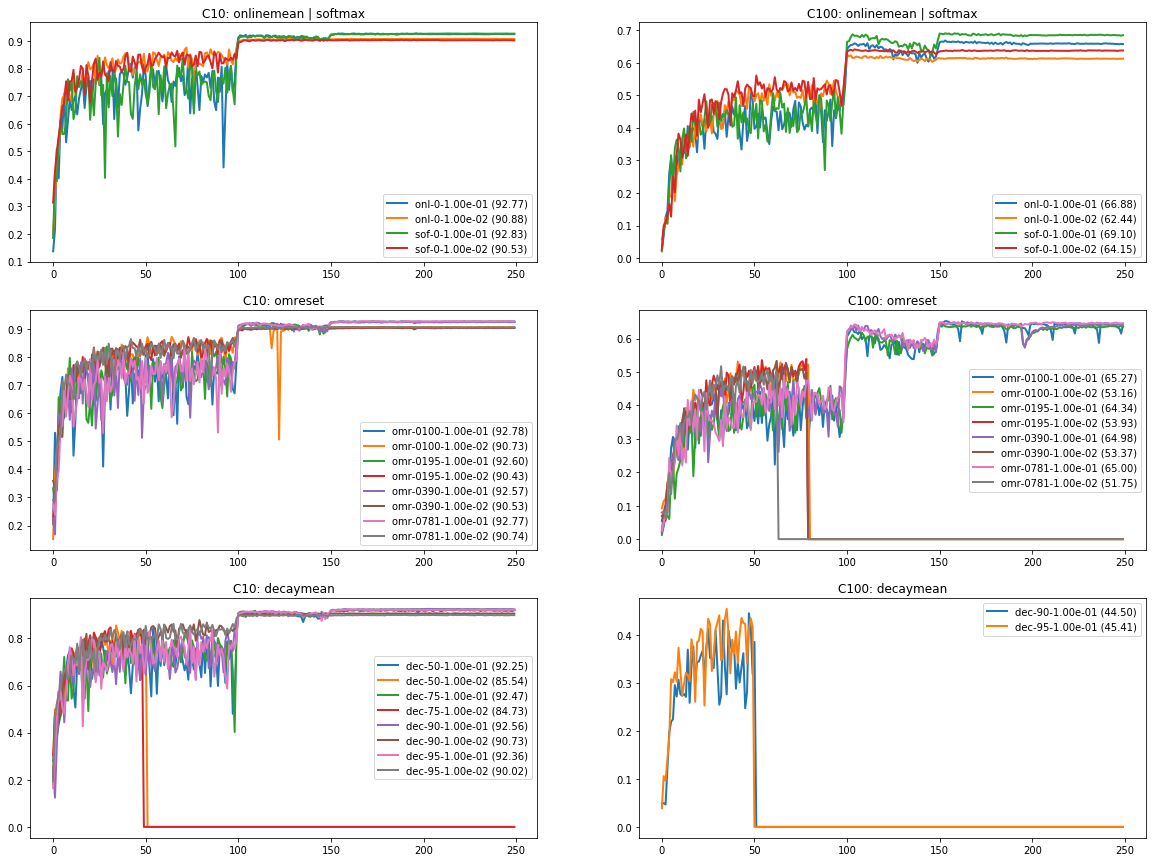

In [126]:
plt.figure(1,figsize=[20,15])
plt.subplot(321)
plot_results_acc(rdict=c10dict,m=["onlinemean","softmax"],opp="|",tStr="C10: ")
plt.subplot(323)
plot_results_acc(rdict=c10dict,m="omreset",tStr="C10: ")
plt.subplot(325)
plot_results_acc(rdict=c10dict,m="decaymean",tStr="C10: ")

plt.subplot(322)
plot_results_acc(rdict=c100dict,m=["onlinemean","softmax"],opp="|",tStr="C100: ")
plt.subplot(324)
plot_results_acc(rdict=c100dict,m="omreset",tStr="C100: ")
plt.subplot(326)
plot_results_acc(rdict=c100dict,m="decaymean",tStr="C100: ")
plt.show()

In [122]:
tStr = ""
t = "hoi"
tStr+=t
print("|%s|" %(tStr))

|hoi|
